In [1]:
pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [3]:
data_path = 'GlobalWeatherRepository.csv'
df = pd.read_csv(data_path)

print("Shape of the dataset:", df.shape)
df.info()

# 1.2 Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

numeric_cols = [
    'temperature_celsius',
    'wind_mph',
    'wind_degree',
    'pressure_mb',
    'humidity',
    'cloud',
    'feels_like_celsius',
    'uv_index',
    'visibility_km',
    'gust_mph',
    'precip_mm',
    'air_quality_Carbon_Monoxide',
    'air_quality_Ozone',
    'air_quality_gb-defra-index',
]
# 1.3 Basic statistics
print("\nDescriptive statistics (numeric columns):")
print(df[numeric_cols].describe())


Shape of the dataset: (62363, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62363 entries, 0 to 62362
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       62363 non-null  object 
 1   location_name                 62363 non-null  object 
 2   latitude                      62363 non-null  float64
 3   longitude                     62363 non-null  float64
 4   timezone                      62363 non-null  object 
 5   last_updated_epoch            62363 non-null  int64  
 6   last_updated                  62363 non-null  object 
 7   temperature_celsius           62363 non-null  float64
 8   temperature_fahrenheit        62363 non-null  float64
 9   condition_text                62363 non-null  object 
 10  wind_mph                      62363 non-null  float64
 11  wind_kph                      62363 non-null  float64
 12  wind_degree               

In [4]:
df['last_updated'] = pd.to_datetime(df['last_updated'])


df.sort_values('last_updated', inplace=True)

# --- Handle outliers ---
# We use the IQR method on temperature & precipitation to remove or cap outliers.
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

print("\nOriginal data size:", len(df))

# Apply outlier removal for air quality and windspeed
df_clean = remove_outliers(df, 'air_quality_Carbon_Monoxide')
df_clean = remove_outliers(df_clean, 'wind_mph')
print("\nShape after outlier removal:", df_clean.shape)

# --- Normalize data ---
# Example: MinMaxScaler for temperature & precipitation
scaler = MinMaxScaler()
df_clean['temp_c_scaled'] = scaler.fit_transform(df_clean[['temperature_celsius']])
df_clean['precip_mm_scaled'] = scaler.fit_transform(df_clean[['precip_mm']])

print("\nHead of the DataFrame after cleaning & normalization:")
print(df_clean.head())



Original data size: 62363

Shape after outlier removal: (56253, 41)

Head of the DataFrame after cleaning & normalization:
                      country    location_name  latitude  longitude  \
186  United States of America  Washington Park     46.60    -120.49   
52                El Salvador     San Salvador     13.71     -89.20   
124                 Nicaragua          Managua     12.15     -86.27   
17                     Belize         Belmopan     17.25     -88.77   
74                   Honduras      Tegucigalpa     14.10     -87.22   

                timezone  last_updated_epoch        last_updated  \
186  America/Los_Angeles          1715849100 2024-05-16 01:45:00   
52   America/El_Salvador          1715849100 2024-05-16 02:45:00   
124      America/Managua          1715849100 2024-05-16 02:45:00   
17        America/Belize          1715849100 2024-05-16 02:45:00   
74   America/Tegucigalpa          1715849100 2024-05-16 02:45:00   

     temperature_celsius  temperature_fa

                             temperature_celsius  wind_mph  wind_degree  \
temperature_celsius                     1.000000  0.125179    -0.047533   
wind_mph                                0.125179  1.000000    -0.013126   
wind_degree                            -0.047533 -0.013126     1.000000   
pressure_mb                            -0.311951 -0.098872    -0.048682   
humidity                               -0.363081 -0.136877    -0.021332   
cloud                                  -0.193096 -0.018921     0.022421   
feels_like_celsius                      0.980799  0.096890    -0.051678   
uv_index                                0.543108  0.071719     0.038919   
visibility_km                           0.079017  0.102708    -0.073211   
gust_mph                                0.132564  0.892492    -0.016546   
precip_mm                               0.011642 -0.014952     0.012225   
air_quality_Carbon_Monoxide            -0.214923 -0.283880     0.050652   
air_quality_Ozone        

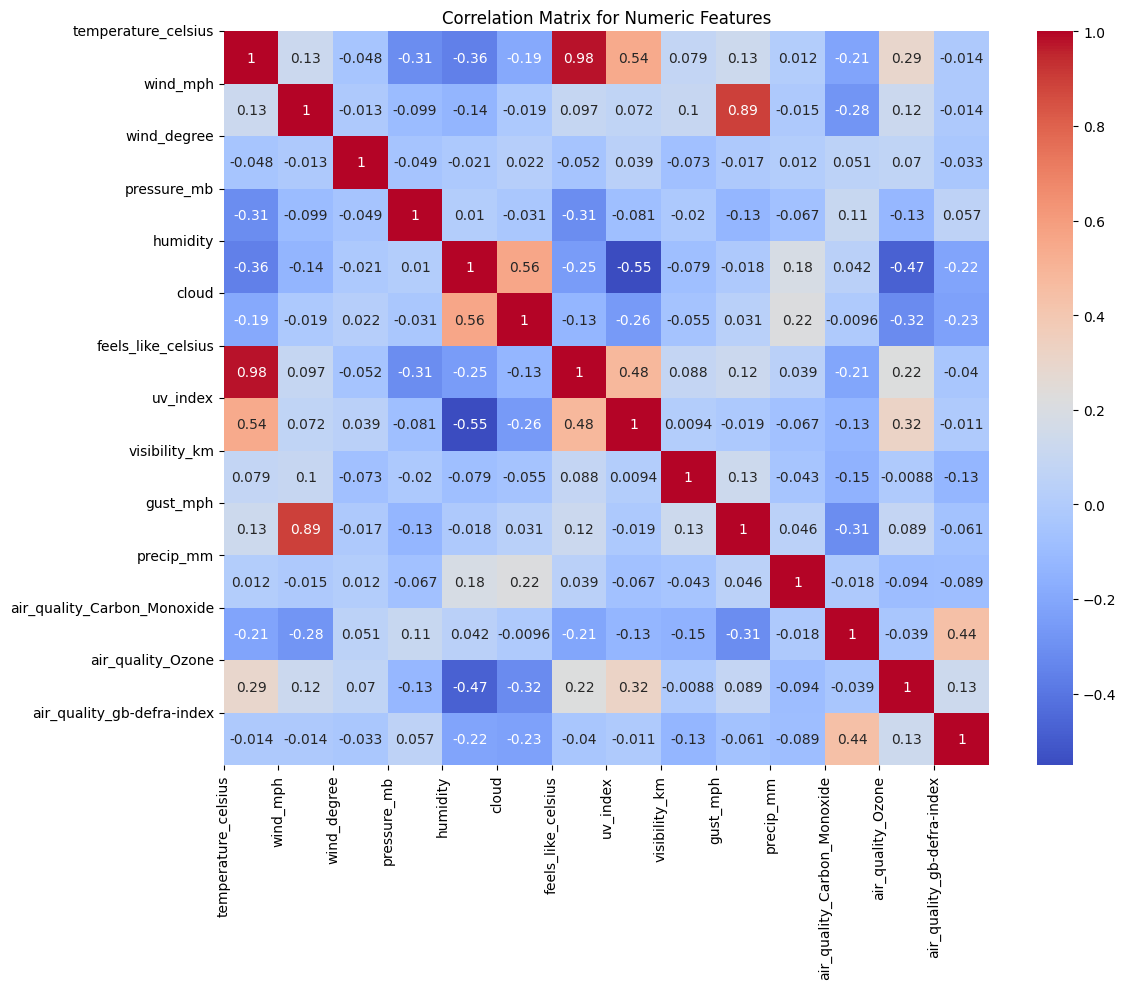

In [9]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)

corr_matrix = df_clean[numeric_cols].corr()
print(corr_matrix)

# Visualize the correlation matrix using matplotlib's imshow
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()

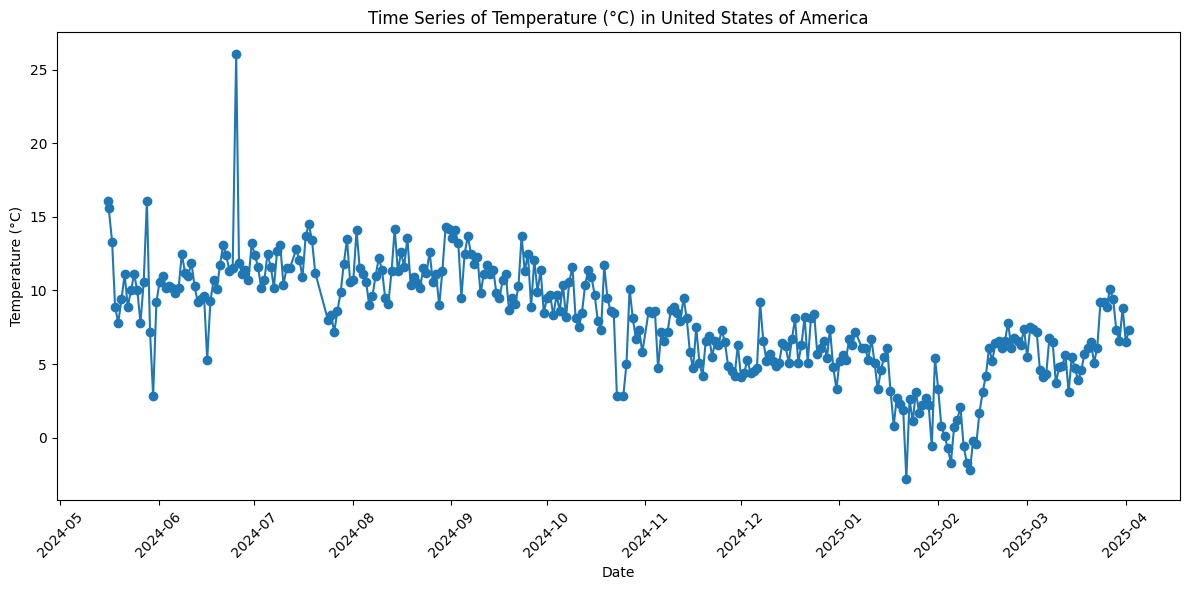

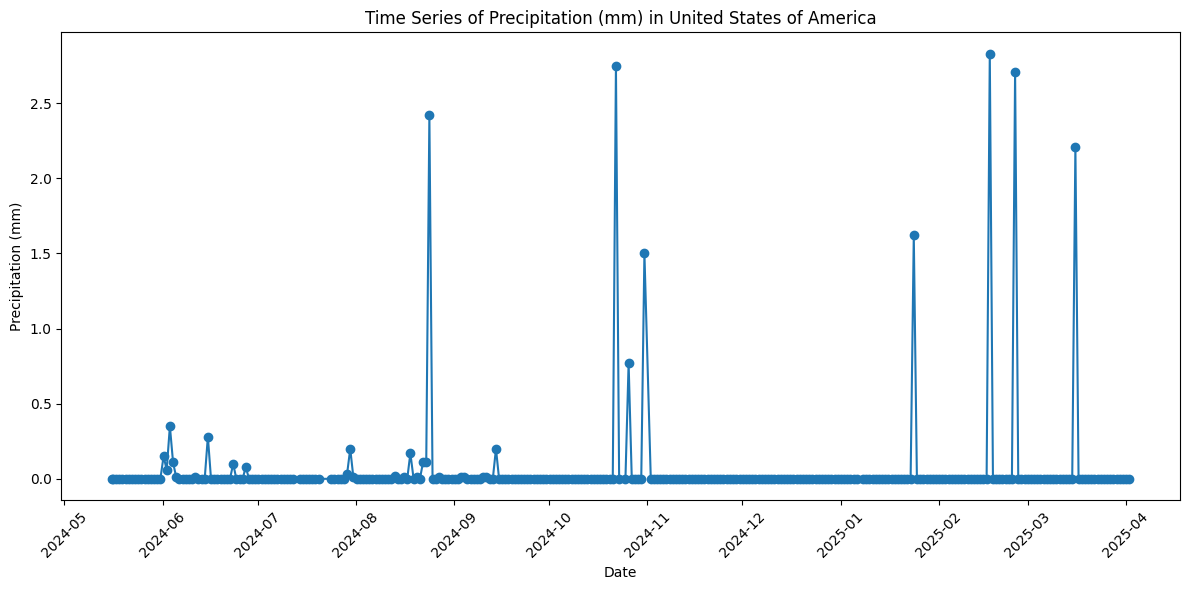

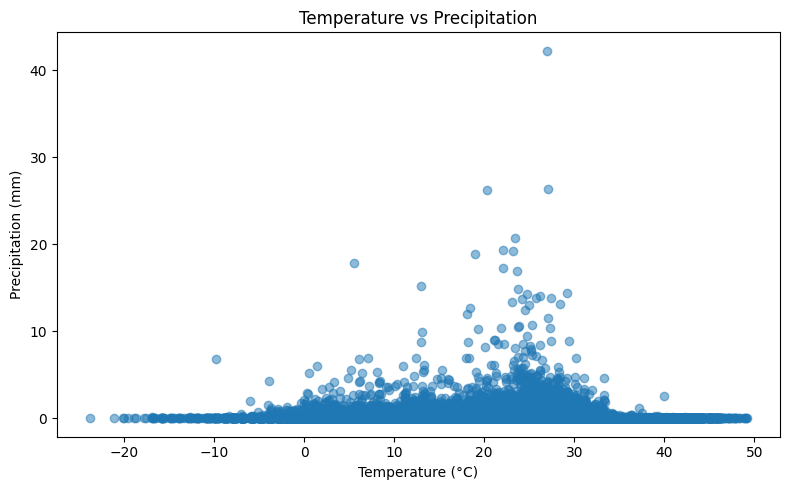

In [6]:
sample_country = 'United States of America'
country_df = df_clean[df_clean['country'] == sample_country].copy()

# Ensure the last_updated column is datetime and sort by date
country_df['last_updated'] = pd.to_datetime(country_df['last_updated'])
country_df.sort_values('last_updated', inplace=True)

# Plot time series of Temperature for the sample country
plt.figure(figsize=(12, 6))
plt.plot(country_df['last_updated'], country_df['temperature_celsius'], marker='o', linestyle='-')
plt.title(f"Time Series of Temperature (°C) in {sample_country}")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot time series of Precipitation for the sample country
plt.figure(figsize=(12, 6))
plt.plot(country_df['last_updated'], country_df['precip_mm'], marker='o', linestyle='-')
plt.title(f"Time Series of Precipitation (mm) in {sample_country}")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_clean['temperature_celsius'], df_clean['precip_mm'], alpha=0.5)
plt.title("Temperature vs Precipitation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.show()



                          PanelOLS Estimation Summary                           
Dep. Variable:          temp_c_scaled   R-squared:                        0.3281
Estimator:                   PanelOLS   R-squared (Between):              0.1475
No. Observations:               56253   R-squared (Within):               0.3281
Date:                Fri, Apr 04 2025   R-squared (Overall):              0.1857
Time:                        01:16:10   Log-likelihood                 6.559e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6840.2
Entities:                         208   P-value                           0.0000
Avg Obs:                       270.45   Distribution:                 F(4,56041)
Min Obs:                       1.0000                                           
Max Obs:                       669.00   F-statistic (robust):             6840.2
                            

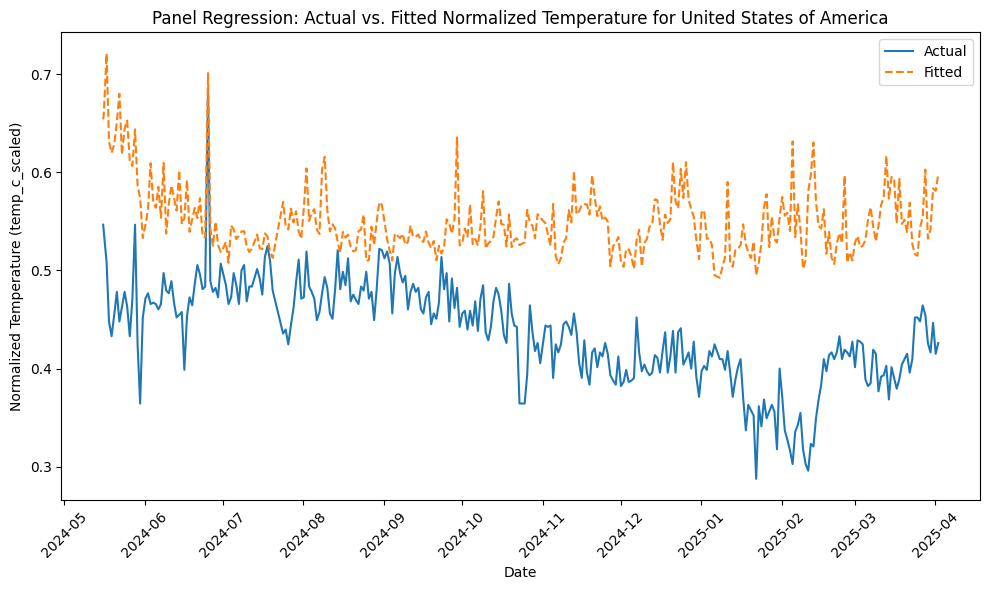

In [7]:
df_panel = df_clean[['country', 'last_updated', 'temp_c_scaled', 'precip_mm_scaled', 'humidity', 'wind_mph', 'pressure_mb']].dropna()

# Ensure the date column is datetime
df_panel['last_updated'] = pd.to_datetime(df_panel['last_updated'])

# Set a multi-index (entity: country, time: last_updated)
df_panel = df_panel.set_index(['country', 'last_updated'])

# ----------------------------
# 1. Fit a Fixed Effects Panel Regression Model
# ----------------------------
# Define independent variables and add a constant
exog_vars = ['precip_mm_scaled', 'humidity', 'wind_mph', 'pressure_mb']
exog = sm.add_constant(df_panel[exog_vars])

# The dependent variable is the normalized temperature
dependent = df_panel['temp_c_scaled']

# Fit a fixed effects model that accounts for differences between countries
panel_model = PanelOLS(dependent, exog, entity_effects=True)
fe_results = panel_model.fit()
print(fe_results.summary)
df_panel['fitted'] = fe_results.fitted_values

# To visualize, select a sample country (for example, 'United States of America')
sample_country = 'United States of America'
sample_data = df_panel.xs(sample_country, level='country')

# Evaluate performance for the entire panel
actual = df_panel['temp_c_scaled']
predicted = df_panel['fitted']

# Calculate metrics
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mse)

print("Evaluation Metrics for the PanelOLS Model:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

plt.figure(figsize=(10, 6))
plt.plot(sample_data.index, sample_data['temp_c_scaled'], label='Actual')
plt.plot(sample_data.index, sample_data['fitted'], label='Fitted', linestyle='--')
plt.title(f'Panel Regression: Actual vs. Fitted Normalized Temperature for {sample_country}')
plt.xlabel("Date")
plt.ylabel("Normalized Temperature (temp_c_scaled)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()